In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, auc, roc_curve, f1_score, r2_score, confusion_matrix, mean_squared_error, mean_absolute_percentage_error

from keras.losses import MeanAbsolutePercentageError
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras import layers
from datetime import datetime
from keras.datasets import mnist
from keras.layers import Dense, LSTM

In [2]:
# CLUSTER 0
df = pd.read_excel("Walmart_clusters.xlsx")
class_0 = df[df["cluster_sklearn"] == 0]

In [3]:
x1 = pd.to_numeric(class_0["Weekly_Sales"], errors="coerce").to_numpy()
x11= pd.to_numeric(class_0["Holiday_Flag"], errors="coerce").to_numpy()
x2 = pd.to_numeric(class_0["Temperature"], errors="coerce").to_numpy()
x3 = pd.to_numeric(class_0["Fuel_Price"], errors="coerce").to_numpy()
x4 = pd.to_numeric(class_0["CPI"], errors="coerce").to_numpy()
x5 = pd.to_numeric(class_0["Unemployment"], errors="coerce").to_numpy()
x6 = pd.to_numeric(class_0["yyyy"], errors="coerce").to_numpy()
x7 = pd.to_numeric(class_0["mm"], errors="coerce").to_numpy()
x8 = pd.to_numeric(class_0["dd"], errors="coerce").to_numpy()
x9 = pd.to_numeric(class_0["week_absolute"], errors="coerce").to_numpy()
x10 = pd.to_numeric(class_0["Date"], errors="coerce").to_numpy()

In [32]:
class_0

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,yyyy,mm,dd,week_relative,week_absolute,Date,cluster_sklearn
0,3,377219,0,65.065,3.234,216.539,7.567,2010,1,1,52,53,2010-01-01,0
1,5,309443,0,61.722,3.234,213.766,6.639,2010,1,1,52,53,2010-01-01,0
2,7,669225,0,27.723,3.179,191.968,8.873,2010,1,1,52,53,2010-01-01,0
3,9,494392,0,59.275,3.234,216.770,6.476,2010,1,1,52,53,2010-01-01,0
4,15,576183,0,37.713,3.600,133.786,7.900,2010,1,1,52,53,2010-01-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2816,38,437321,0,71.740,4.468,131.108,10.199,2012,12,28,157,52,2012-12-28,0
2817,42,612380,0,76.030,4.468,131.108,6.943,2012,12,28,157,52,2012-12-28,0
2818,43,619370,0,71.140,3.601,214.677,8.839,2012,12,28,157,52,2012-12-28,0
2819,44,337796,0,55.100,3.797,131.108,5.217,2012,12,28,157,52,2012-12-28,0


In [6]:
# class_0.info()

In [4]:
scaler = MinMaxScaler()

x_list = [x1, x11, x2, x3, x4, x5, x6, x7, x9]
features = []

for i in x_list:
    i = scaler.fit_transform(i.reshape(-1,1))
    features.append(i)
    x = np.concatenate(features,  axis=1)


In [6]:
x.shape

(2821, 9)

In [38]:
import joblib
# from sklearn.externals import joblib

scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 

['scaler.save']

In [7]:
# zamiana danych na sekwencję, wymagają tego warstwy rekurencyjne
# długość sekwencji zależy od tego po jakiej ilości próbek w czasie chcemy aby rekurencja chodziła
def ConvertDataToSequence(data, windowLen, featNum):
    """
    :param data: dane w postaci szeregu, typu numpy.array, shape=(N,Feat)
    :param windowLen: długość okna czyli długość sekwencji
    :param featNum: ilość cech w ramach szeregu
    """
    #długość wejściowego szeregu
    lenOfAllSeq = data.shape[0]
    # pusty kontener na kolejne sekwencje
    xSeq = []
    # idziemy po szeregu i tworzymy z niego sekwencje
    for i in range(lenOfAllSeq-windowLen):
        xSeq.append(data[i:i+windowLen])
    xSeq = np.array(xSeq).reshape(-1,windowLen,featNum)
    
    # definiujemy wartości następujące po każdej sekwencji, będą to nasze wyjścia
    y = data[windowLen:,0].reshape(-1,1)
    
    return xSeq, y

In [8]:
seqLen = 6
featNum = 9
xSeq, y = ConvertDataToSequence(x, seqLen, featNum)
print(f"sequence shape: {xSeq.shape}")
print(f"output shape: {y.shape}")

sequence shape: (2815, 6, 9)
output shape: (2815, 1)


In [28]:
# xSeq_train[1]

In [9]:
test_percent = 0.1

In [10]:
x_len = xSeq.shape[0]

In [11]:
x_train_num = int(x_len*(1.0-test_percent))
x_test_num = int(x_len*test_percent)

In [12]:
xSeq_train = xSeq[:x_train_num]
xSeq_test = xSeq[-x_test_num:]

In [13]:
y_train = y[:x_train_num]
y_test = y[-x_test_num:]

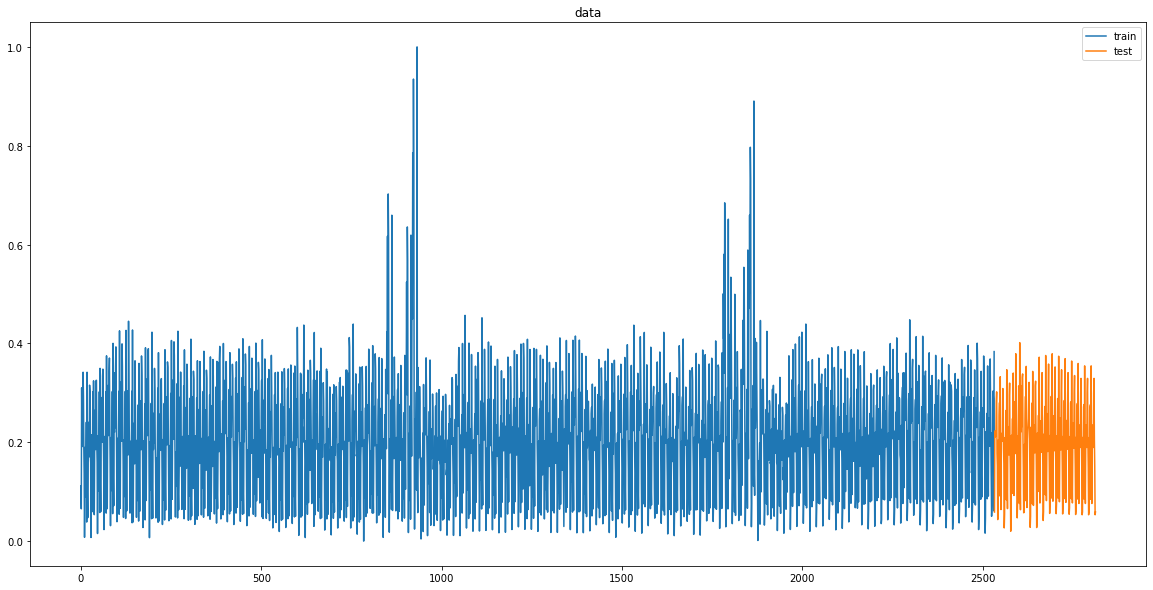

In [14]:
fig = plt.figure(figsize=(20,10))
plt.plot(np.arange(x_train_num), xSeq_train[:,0,0])
plt.plot(np.arange(x_train_num, x_len-1), xSeq_test[:,0,0])
plt.legend(["train","test"])
plt.title("data")
plt.show()

In [15]:
modelRNN = tf.keras.Sequential()

modelRNN.add(
    layers.LSTM(
        units=128,
        input_shape=(seqLen, featNum),
        name="rekurencja_pierwsza",
        return_sequences=True
    )
)

modelRNN.add(
    layers.Dropout(0.0)
)

modelRNN.add(
    layers.LSTM(
        units=128,
        name="rekurencja_druga"
    )
)

modelRNN.add(
    layers.Dense(
        units=128,
        activation="relu"
    )
)

modelRNN.add(
    layers.Dropout(0.0)
)

modelRNN.add(
    layers.Dense(
        units=1,
        name="wyjscie"
    )
)

modelRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rekurencja_pierwsza (LSTM)  (None, 6, 128)            70656     
                                                                 
 dropout (Dropout)           (None, 6, 128)            0         
                                                                 
 rekurencja_druga (LSTM)     (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 wyjscie (Dense)             (None, 1)                 129       
                                                                 
Total params: 218,881
Trainable params: 218,881
Non-trai

In [16]:
modelRNN.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=MeanAbsolutePercentageError()
)

In [17]:
history = modelRNN.fit(
    x=xSeq_train,
    y=y_train,
    epochs=20,
    batch_size=4,
    validation_data=(xSeq_test, y_test)
    
)

Epoch 1/20
634/634 [==============================] - 12s 13ms/step - loss: 18471.0840 - val_loss: 52.8724
Epoch 2/20
634/634 [==============================] - 6s 9ms/step - loss: 37588.3047 - val_loss: 2166.1138
Epoch 3/20
634/634 [==============================] - 6s 9ms/step - loss: 42136.2344 - val_loss: 75.4770
Epoch 4/20
634/634 [==============================] - 6s 9ms/step - loss: 57713.5898 - val_loss: 57.8138
Epoch 5/20
634/634 [==============================] - 6s 9ms/step - loss: 52178.6680 - val_loss: 56.5050
Epoch 6/20
634/634 [==============================] - 6s 10ms/step - loss: 102391.2031 - val_loss: 62.1679
Epoch 7/20
634/634 [==============================] - 6s 10ms/step - loss: 43884.4609 - val_loss: 84.2937
Epoch 8/20
634/634 [==============================] - 6s 10ms/step - loss: 6312815.5000 - val_loss: 57.6591
Epoch 9/20
634/634 [==============================] - 7s 10ms/step - loss: 1115236.3750 - val_loss: 58.5174
Epoch 10/20
634/634 [=====================

In [18]:
y_pred = modelRNN.predict(xSeq_test)

In [19]:
xSeq_test.shape

(281, 6, 9)

In [20]:
y_pred

array([[0.1783796 ],
       [0.1763846 ],
       [0.17469868],
       [0.18249702],
       [0.17731592],
       [0.1765795 ],
       [0.17867664],
       [0.18415016],
       [0.18165916],
       [0.19287673],
       [0.17758864],
       [0.1845409 ],
       [0.18534714],
       [0.18041319],
       [0.1701684 ],
       [0.17786318],
       [0.16640538],
       [0.17264143],
       [0.179131  ],
       [0.17690745],
       [0.17541099],
       [0.18253392],
       [0.1783126 ],
       [0.17711902],
       [0.17910355],
       [0.1844239 ],
       [0.18272665],
       [0.19327578],
       [0.17870802],
       [0.18538812],
       [0.18591607],
       [0.18072093],
       [0.17013326],
       [0.17816341],
       [0.16518655],
       [0.17120901],
       [0.17865747],
       [0.17627051],
       [0.1751155 ],
       [0.18357661],
       [0.17809525],
       [0.17654777],
       [0.17913398],
       [0.18315911],
       [0.1812203 ],
       [0.19298834],
       [0.17784938],
       [0.185

In [21]:
print(mean_squared_error(y_test,y_pred))
print(r2_score(y_test,y_pred))
print(mean_absolute_percentage_error(y_test,y_pred))

0.009919600167355325
-0.16065931337777362
0.6760342513644877


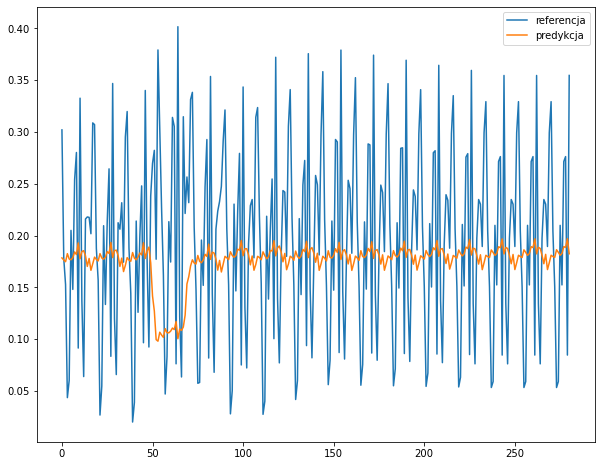

In [22]:
fig = plt.figure(figsize=(10,8))
plt.plot(y_test)
plt.plot(y_pred.reshape(-1))

plt.legend(["referencja", "predykcja"])
plt.show()

In [23]:
y_pred

array([[0.1783796 ],
       [0.1763846 ],
       [0.17469868],
       [0.18249702],
       [0.17731592],
       [0.1765795 ],
       [0.17867664],
       [0.18415016],
       [0.18165916],
       [0.19287673],
       [0.17758864],
       [0.1845409 ],
       [0.18534714],
       [0.18041319],
       [0.1701684 ],
       [0.17786318],
       [0.16640538],
       [0.17264143],
       [0.179131  ],
       [0.17690745],
       [0.17541099],
       [0.18253392],
       [0.1783126 ],
       [0.17711902],
       [0.17910355],
       [0.1844239 ],
       [0.18272665],
       [0.19327578],
       [0.17870802],
       [0.18538812],
       [0.18591607],
       [0.18072093],
       [0.17013326],
       [0.17816341],
       [0.16518655],
       [0.17120901],
       [0.17865747],
       [0.17627051],
       [0.1751155 ],
       [0.18357661],
       [0.17809525],
       [0.17654777],
       [0.17913398],
       [0.18315911],
       [0.1812203 ],
       [0.19298834],
       [0.17784938],
       [0.185

In [26]:
rev_trans = scaler.inverse_transform(y_pred)

In [24]:
y_pred = scaler.inverse_transform(y_pred)

In [25]:
y_pred

array([[10.275739 ],
       [10.171999 ],
       [10.0843315],
       [10.489845 ],
       [10.2204275],
       [10.182135 ],
       [10.291185 ],
       [10.575809 ],
       [10.446277 ],
       [11.02959  ],
       [10.23461  ],
       [10.596127 ],
       [10.638051 ],
       [10.381486 ],
       [ 9.848757 ],
       [10.248885 ],
       [ 9.65308  ],
       [ 9.977354 ],
       [10.314812 ],
       [10.199187 ],
       [10.121371 ],
       [10.491764 ],
       [10.272255 ],
       [10.210189 ],
       [10.313385 ],
       [10.590042 ],
       [10.501786 ],
       [11.050341 ],
       [10.292817 ],
       [10.6401825],
       [10.667635 ],
       [10.397488 ],
       [ 9.84693  ],
       [10.264497 ],
       [ 9.589701 ],
       [ 9.902868 ],
       [10.290189 ],
       [10.166067 ],
       [10.106006 ],
       [10.545984 ],
       [10.260953 ],
       [10.180484 ],
       [10.314967 ],
       [10.524274 ],
       [10.423455 ],
       [11.035394 ],
       [10.248168 ],
       [10.62

In [20]:
modelRNN.save("Projekt_DL/model_0.h5")

In [26]:
modelRNN.save("/Users/Dell/Desktop/kurs_data_science/DL/DL PROJEKT/app_clusters/modele_klastry/model_k0_new.h5")

In [27]:
dataset = pd.DataFrame(data=list(zip(y_pred[:11], y_test[:11])))

In [28]:
dataset

,0,1
0,[10.275739],[0.30197832472620056]
1,[10.171999],[0.1780335719010919]
2,[10.0843315],[0.1526109966215756]
3,[10.489845],[0.043475775254470744]
4,[10.2204275],[0.060133775804383505]
5,[10.182135],[0.20493369740098163]
6,[10.291185],[0.1479632810734732]
7,[10.575809],[0.25399435386613156]
8,[10.446277],[0.28016897566499965]
9,[11.02959],[0.09132703202288942]


In [29]:
y_pred

array([[10.275739 ],
       [10.171999 ],
       [10.0843315],
       [10.489845 ],
       [10.2204275],
       [10.182135 ],
       [10.291185 ],
       [10.575809 ],
       [10.446277 ],
       [11.02959  ],
       [10.23461  ],
       [10.596127 ],
       [10.638051 ],
       [10.381486 ],
       [ 9.848757 ],
       [10.248885 ],
       [ 9.65308  ],
       [ 9.977354 ],
       [10.314812 ],
       [10.199187 ],
       [10.121371 ],
       [10.491764 ],
       [10.272255 ],
       [10.210189 ],
       [10.313385 ],
       [10.590042 ],
       [10.501786 ],
       [11.050341 ],
       [10.292817 ],
       [10.6401825],
       [10.667635 ],
       [10.397488 ],
       [ 9.84693  ],
       [10.264497 ],
       [ 9.589701 ],
       [ 9.902868 ],
       [10.290189 ],
       [10.166067 ],
       [10.106006 ],
       [10.545984 ],
       [10.260953 ],
       [10.180484 ],
       [10.314967 ],
       [10.524274 ],
       [10.423455 ],
       [11.035394 ],
       [10.248168 ],
       [10.62